In [1]:
import time
# import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## **Finding Optimal Key**

In [2]:
from NOA import NOA  # assuming the NOA function is defined in a separate file
from Get_Functions_details import Get_Functions_details  

SearchAgents_no = 27  # Number of search agents basis on no. of round of speck params
Function_name = 11 # Name of the test function that can be from F1 to F23 (Table 1,2,3 in the paper)
Max_iteration = 500  # Maximum numbef of iterations

# Load details of the selected benchmark function
lb, ub, dim, fobj = Get_Functions_details(Function_name)

Best_score, Best_pos, Convergence_curve, t = NOA(SearchAgents_no, Max_iteration, ub, lb, dim, fobj)

print('The best solution obtained by NOA is: ', Best_pos)
print('The best optimal value of the objective function found by NOA is: ', Best_score)

The best solution obtained by NOA is:  [ 7.90238601e+01  1.14815019e+02 -5.94084965e+02 -1.84273542e+01
 -1.79623726e+02  2.65926280e+02 -6.50132414e+01  3.44178722e+02
 -3.21461994e+02  1.85255963e+02 -4.15136385e+02 -2.78347433e+02
 -1.33493782e+02 -2.66443362e+02  1.69635716e+02 -1.47201018e-04
 -7.09766722e+00  4.52406019e+02  3.24127778e+02 -1.64180241e+02
  1.37204674e+02 -4.27654435e+01 -6.00000000e+02  3.94651595e+01
  8.69508817e+01 -7.72764020e+01  2.04483030e+01  3.62840874e+02
  4.02391787e+02  4.80533297e+01  8.92768233e+01 -2.78504096e+02
 -1.96835651e+02  3.73706397e+02 -7.97403586e+01  3.00332862e+02
  2.03510207e+02 -1.87294546e+02 -2.52391494e+02 -3.35462432e+02
 -3.81101944e+02  6.75915498e+01 -1.83064202e+02 -9.44786989e+01
 -2.87730908e+02 -2.85785301e+02 -4.35602844e+02 -1.47688521e+02
 -1.07292541e+02  3.76961180e-05  1.21859870e+02 -4.28436674e+02
 -5.00260437e+02  2.38441675e-01  1.48856348e+02 -5.41422883e+02
  3.23128052e+02  1.32733122e+02 -4.50224886e+02  7

In [3]:
from ctypes import *
# Find Optimal Key using the 1st index value of Best position
key = max(Best_pos)

# If the key is float
opt_key = cast(pointer(c_float(key)), POINTER(c_int32)).contents.value

## **Encryption And Decryption** 

In [4]:
def float_encrypt(x, w):
	bits = cast(pointer(c_float(x)), POINTER(c_int32)).contents.value
	e = w.encrypt(bits)
	return e


def encrypt_dataset(filename, my_simon):
	df = pd.read_csv(filename)
	cipher = [[0 for _ in range(len(df.iloc[0,:]))] for _ in range(len(df))]

	encrypt_times = [] # stroring encryption times
	per = 5 # measuring time for 5th segment of data
	start = time.time()

	for i in range(len(df)):
		for j in range(len(df.iloc[0,:])):
			cipher[i][j] = hex(float_encrypt(df.iloc[i,j], my_simon))
		
		if (i == len(df)//per -1):
			end = time.time()
			encrypt_times.append(round(end - start, 2))
			per-=1
	
	df1 = pd.DataFrame(cipher, columns=df.columns)
	df1.to_csv(f"Cipher_{filename}", index = False)  # header=df.columns
			
	return df1, encrypt_times

In [5]:
def float_decrypt(e, w):
	d = w.decrypt(e)
	y = cast(pointer(c_int32(d)), POINTER(c_float)).contents.value
	return round(y,2)


def decrypt_dataset(filename, my_simon):
	df = pd.read_csv(filename)
	decrypt_plain = [[0 for _ in range(len(df.iloc[0,:]))] for _ in range(len(df))]

	decrypt_times = [] # stroring decryption times
	per = 5 # measuring time for 5th segment of data
	start = time.time()

	for i in range(len(df)):
		for j in range(len(df.iloc[0,:])):
			decrypt_plain[i][j] = float_decrypt(int(df.iloc[i,j], 0), my_simon)
		
		if (i == len(df)//per -1):
			end = time.time()
			decrypt_times.append(round(end - start, 2))
			per-=1

	df1 = pd.DataFrame(decrypt_plain, columns=df.columns)
	df1.to_csv(f"Decrypt_{filename}", index = False)	#  header=df.columns
		
	return df1, decrypt_times

In [6]:
from speck import SpeckCipher
my_speck = SpeckCipher(opt_key, key_size=128, block_size=64)

### For EEG Eye State dataset

In [7]:
plainfile1 = "EEG_Eye_State.csv"
cipherData1, encrypt_times1 = encrypt_dataset(plainfile1, my_speck)
decryptData1, decrypt_times1 = decrypt_dataset('Cipher_'+plainfile1, my_speck)

In [8]:
data_size = [20, 40, 60, 80, 100]
column = {  "Data Size":data_size,
			"Encryption Time (Sec.)": encrypt_times1, 
			"Decryption Time (Sec.)": decrypt_times1, 
		}	

times_df1 = pd.DataFrame(column)
times_df1

,Data Size,Encryption Time (Sec.),Decryption Time (Sec.)
0,20,2.47,2.43
1,40,3.08,3.03
2,60,4.19,4.06
3,80,6.38,6.18
4,100,12.50,12.56


In [9]:
pd.read_csv(plainfile1).head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Class
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,1
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,1
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,1
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,1
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,1


In [10]:
decryptData1.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,Class
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,1.0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,1.0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,1.0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,1.0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,1.0


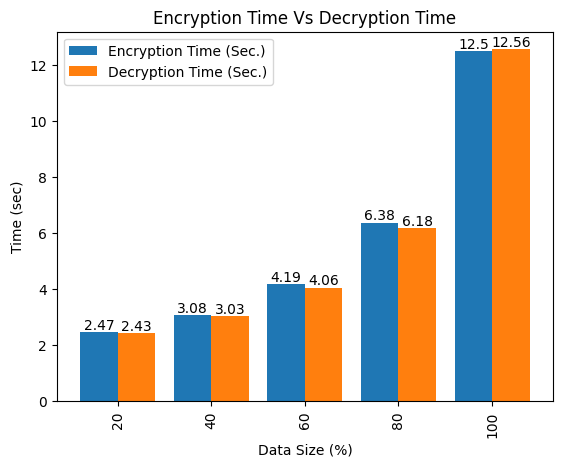

In [11]:
ax = times_df1.plot(kind ='bar', x ='Data Size', width=0.8)

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Data Size (%)')
plt.ylabel('Time (sec)')
plt.title("Encryption Time Vs Decryption Time")
plt.show()

### For Patient Treatement Classification dataset

In [12]:
# # Load dataset into the memory
# data = pd.read_csv('data-ori.csv')

# # Encoding the features
# data['SEX'] = data.SEX.replace({"M":1, 'F':0})
# data['SOURCE'] = data.SOURCE.replace({"in":1, 'out':0})

In [13]:
# data.to_csv("PTC.csv", index=False)

In [14]:
plainfile2 = "PTC.csv"
cipherData2, encrypt_times2 = encrypt_dataset(plainfile2, my_speck)
decryptData2, decrypt_times2 = decrypt_dataset('Cipher_'+plainfile2, my_speck)

In [15]:
data_size = [20, 40, 60, 80, 100]
column = {  "Data Size":data_size,
			"Encryption Time (Sec.)": encrypt_times2, 
			"Decryption Time (Sec.)": decrypt_times2, 
		}	
times_df2 = pd.DataFrame(column)
times_df2

,Data Size,Encryption Time (Sec.),Decryption Time (Sec.)
0,20,0.49,0.55
1,40,0.61,0.69
2,60,0.82,0.90
3,80,1.32,1.35
4,100,2.79,2.75


In [16]:
pd.read_csv(plainfile2).head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310,25.4,33.6,75.5,1,0,0
1,43.5,14.8,5.39,12.7,334,27.5,34.0,80.7,1,0,0
2,33.5,11.3,4.74,13.2,305,23.8,33.7,70.7,1,0,0
3,39.1,13.7,4.98,10.5,366,27.5,35.0,78.5,1,0,0
4,30.9,9.9,4.23,22.1,333,23.4,32.0,73.0,1,1,0


In [17]:
decryptData2.head()

,HAEMATOCRIT,HAEMOGLOBINS,ERYTHROCYTE,LEUCOCYTE,THROMBOCYTE,MCH,MCHC,MCV,AGE,SEX,SOURCE
0,35.1,11.8,4.65,6.3,310.0,25.4,33.6,75.5,1.0,0.0,0.0
1,43.5,14.8,5.39,12.7,334.0,27.5,34.0,80.7,1.0,0.0,0.0
2,33.5,11.3,4.74,13.2,305.0,23.8,33.7,70.7,1.0,0.0,0.0
3,39.1,13.7,4.98,10.5,366.0,27.5,35.0,78.5,1.0,0.0,0.0
4,30.9,9.9,4.23,22.1,333.0,23.4,32.0,73.0,1.0,1.0,0.0


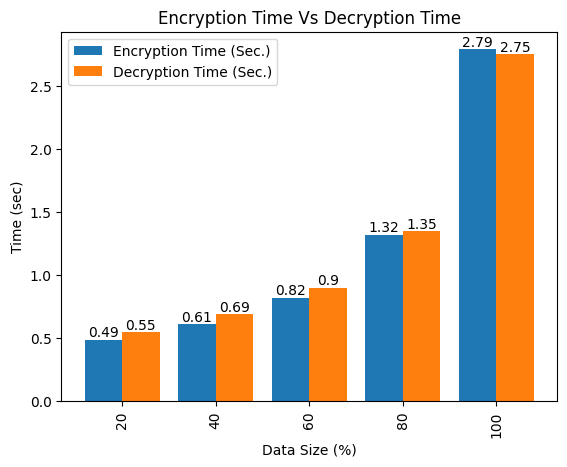

In [18]:
ax = times_df2.plot(kind ='bar', x ='Data Size', width =0.8)

for container in ax.containers:
    ax.bar_label(container)

plt.xlabel('Data Size (%)')
plt.ylabel('Time (sec)')
plt.title("Encryption Time Vs Decryption Time")
plt.show()